In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from fast_hdbscan.numba_kdtree import kdtree_to_numba
from fast_hdbscan.numba_kdtree import parallel_tree_query
from sklearn.neighbors import KDTree

CPU times: user 11.2 s, sys: 422 ms, total: 11.7 s
Wall time: 9.37 s


In [2]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"

In [3]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [4]:
graph.cardinalities.describe()

count    304554.000000
mean          6.751085
std           2.060782
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          82.000000
Name: cardinalities, dtype: float64

In [5]:
# graph2 = graph.higher_order(lower_order=True, k=2, diagonal=True)
# graph2.cardinalities.describe()

In [6]:
# graph3 = graph.higher_order(lower_order=True, k=3, diagonal=True)
# graph3

In [7]:
from core.cluster_validation import print_distance, generate_neigbhourhood_groups

In [8]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [9]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')



X_train = X_train[X_train.index >= 0]



spatial_lag = 3


# lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')

lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}.parquet')



# X_train = X_train.join(lag[[c for c in lag.columns if '_median' in c]], how='inner')
X_train = X_train.join(lag, how='inner')


In [10]:
vals = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)

vals = np.nan_to_num(X_train)
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)


# X_train = X_train.clip(-10, 10)

In [11]:
X_train.shape

(299064, 248)

In [12]:
# X_train = pd.read_parquet('../data/old_prague_data/old_prague_data.parquet')
# X_train = X_train.set_index('uID').sort_index()


# vals = np.nan_to_num(StandardScaler().fit_transform(X_train))
# X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
# # X_train = X_train.clip(-10, 10)

# vals = np.nan_to_num(X_train)
# X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)



In [13]:
# tessellation = gpd.read_file('../data/old_prague_data/prg_geometry.gpkg', 
#                              layer='tessellation').set_index('uID').sort_index().to_crs(epsg=3035)
# from libpysal.graph import Graph
# graph = Graph.build_fuzzy_contiguity(tessellation, buffer=.001)

In [30]:
tess_groups = generate_neigbhourhood_groups(tessellation[tessellation.index.isin(X_train.index)])
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

In [31]:
neighbourhoods = X_train.loc[tess_groups.index].groupby(tess_groups.values).mean()
print_distance(neighbourhoods, metric='euclidean')

,holyne,housing estate,josefov,karlin,mala strana,malesice,nusle,stare mesto,vinohrady
holyne,0.000000,10.200463,21.471225,21.372109,27.911011,22.275167,12.205975,27.534180,21.962787
housing estate,10.200463,0.000000,17.542557,17.264538,27.493049,21.761749,7.521721,25.190502,17.176847
josefov,21.471225,17.542557,0.000000,14.045140,20.634179,29.311334,13.766314,12.920035,12.948496
karlin,21.372109,17.264538,14.045140,0.000000,22.251963,24.854799,15.467313,17.152240,10.013895
mala strana,27.911011,27.493049,20.634179,22.251963,0.000000,33.532687,24.929454,13.297023,26.386932
malesice,22.275167,21.761749,29.311334,24.854799,33.532687,0.000000,22.692491,33.131050,27.973932
nusle,12.205975,7.521721,13.766314,15.467313,24.929454,22.692491,0.000000,22.112099,14.890648
stare mesto,27.534180,25.190502,12.920035,17.152240,13.297023,33.131050,22.112099,0.000000,20.173909
vinohrady,21.962787,17.176847,12.948496,10.013895,26.386932,27.973932,14.890648,20.173909,0.000000


In [16]:
from scipy.spatial.distance import pdist

In [17]:
for i, g in X_train.loc[tess_groups.index].groupby(tess_groups.values):
    print(i, np.median(pdist(g)))

holyne 14.861031066794668
housing estate 12.898319517292602
josefov 15.379205913100982
karlin 17.629432749965968
mala strana 31.194500423210485
malesice 19.508783965247943
nusle 16.593301220937185
stare mesto 22.13919854956777
vinohrady 12.498921845976499


In [16]:
# tessellation.loc[tess_groups.index].explore(column=tess_groups.values, categorical=True)

In [19]:
newgraph = graph.subgraph(X_train.index.values)

In [20]:
newgraph.component_labels.value_counts()

component labels
776    60555
452    25177
754    17243
99     15583
726    13382
       ...  
427        1
426        1
896        1
893        1
891        1
Name: count, Length: 919, dtype: int64

In [36]:
main_comp = 0

In [37]:
import lonboard
from sidecar import Sidecar
from libpysal.graph import Graph
from lonboard.colormap import apply_continuous_cmap
from core.cluster_validation import get_color

In [38]:
plotting = tessellation.loc[newgraph.component_labels[newgraph.component_labels == main_comp].index]

In [39]:
%%time
layer = lonboard.PolygonLayer.from_geopandas(plotting, opacity=.15)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 7.84 s, sys: 304 ms, total: 8.15 s
Wall time: 8.14 s


Create a Sidecar view (assumes JupyterLab) for more comfortable experience.

In [40]:


sc = Sidecar(title='buildings')

Create a Map object

In [41]:
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)

Display map within the sidecar plugin

In [42]:
with sc:
    display(m)

In [43]:
plot_data = X_train.loc[newgraph.component_labels[newgraph.component_labels == main_comp].index]
plot_graph = newgraph.higher_order(k=3, lower_order=True, diagonal=True).subgraph(plot_data.index)

In [44]:
focals = plot_graph._adjacency.index.get_level_values(0).values
neighbours = plot_graph._adjacency.index.get_level_values(1).values
fvals = plot_data.loc[focals].values
nvals = plot_data.loc[neighbours].values

In [45]:
distances = np.sqrt(np.sum(np.pow(fvals - nvals, 2), axis=1))

In [46]:
# %%time
# from scipy.spatial.distance import cosine
# distances = [cosine(fvals[i], nvals[i]) for i in range(fvals.shape[0])]
# distances = np.array(distances)

In [47]:
pd.Series(distances).describe().iloc[1:]

mean     12.869492
std       6.703990
min       0.000000
25%       9.248641
50%      11.955887
75%      15.392705
max     272.764101
dtype: float64

In [58]:
threshold = 8


In [59]:
new_focals = focals[np.where(distances <= threshold)]
new_neighbours = neighbours[np.where(distances <= threshold)]
new_distances = distances[np.where(distances <= threshold)]

subgraph = Graph.from_arrays(new_focals, new_neighbours, new_distances)

In [60]:
# tessellation.loc[subgraph.component_labels[subgraph.component_labels == 78865].index].explore()

In [61]:
ntop = 100

top_components = subgraph.component_labels.value_counts()

labels = subgraph.component_labels.copy()
top_labels = top_components[:ntop].index.values
labels[~labels.isin(top_labels)] = -1
repl_dict = dict(zip(top_labels.tolist(), np.arange(ntop).tolist()))
labels = labels.replace(repl_dict)

In [62]:
layer.get_fill_color = get_color(labels)

### Hierarchical

In [21]:
# embedding = X_train[[c for c in X_train.columns if '_median' in c]]
embedding = X_train

In [22]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score

In [23]:
clustering_graph = graph.subgraph(X_train.index.values).transform('B').sparse

In [24]:
clusterer = AgglomerativeClustering(linkage='ward',
                                    connectivity=clustering_graph, 
                                    compute_full_tree=True, compute_distances=True)

In [25]:
%%time
model = clusterer.fit(embedding)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:323: UserWarning: the number of connected components of the connectivity matrix is 919 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


CPU times: user 1h 55min 29s, sys: 53min 57s, total: 2h 49min 27s
Wall time: 9min 46s


In [26]:
def get_linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix

In [27]:
linkage_matrix = get_linkage_matrix(model)

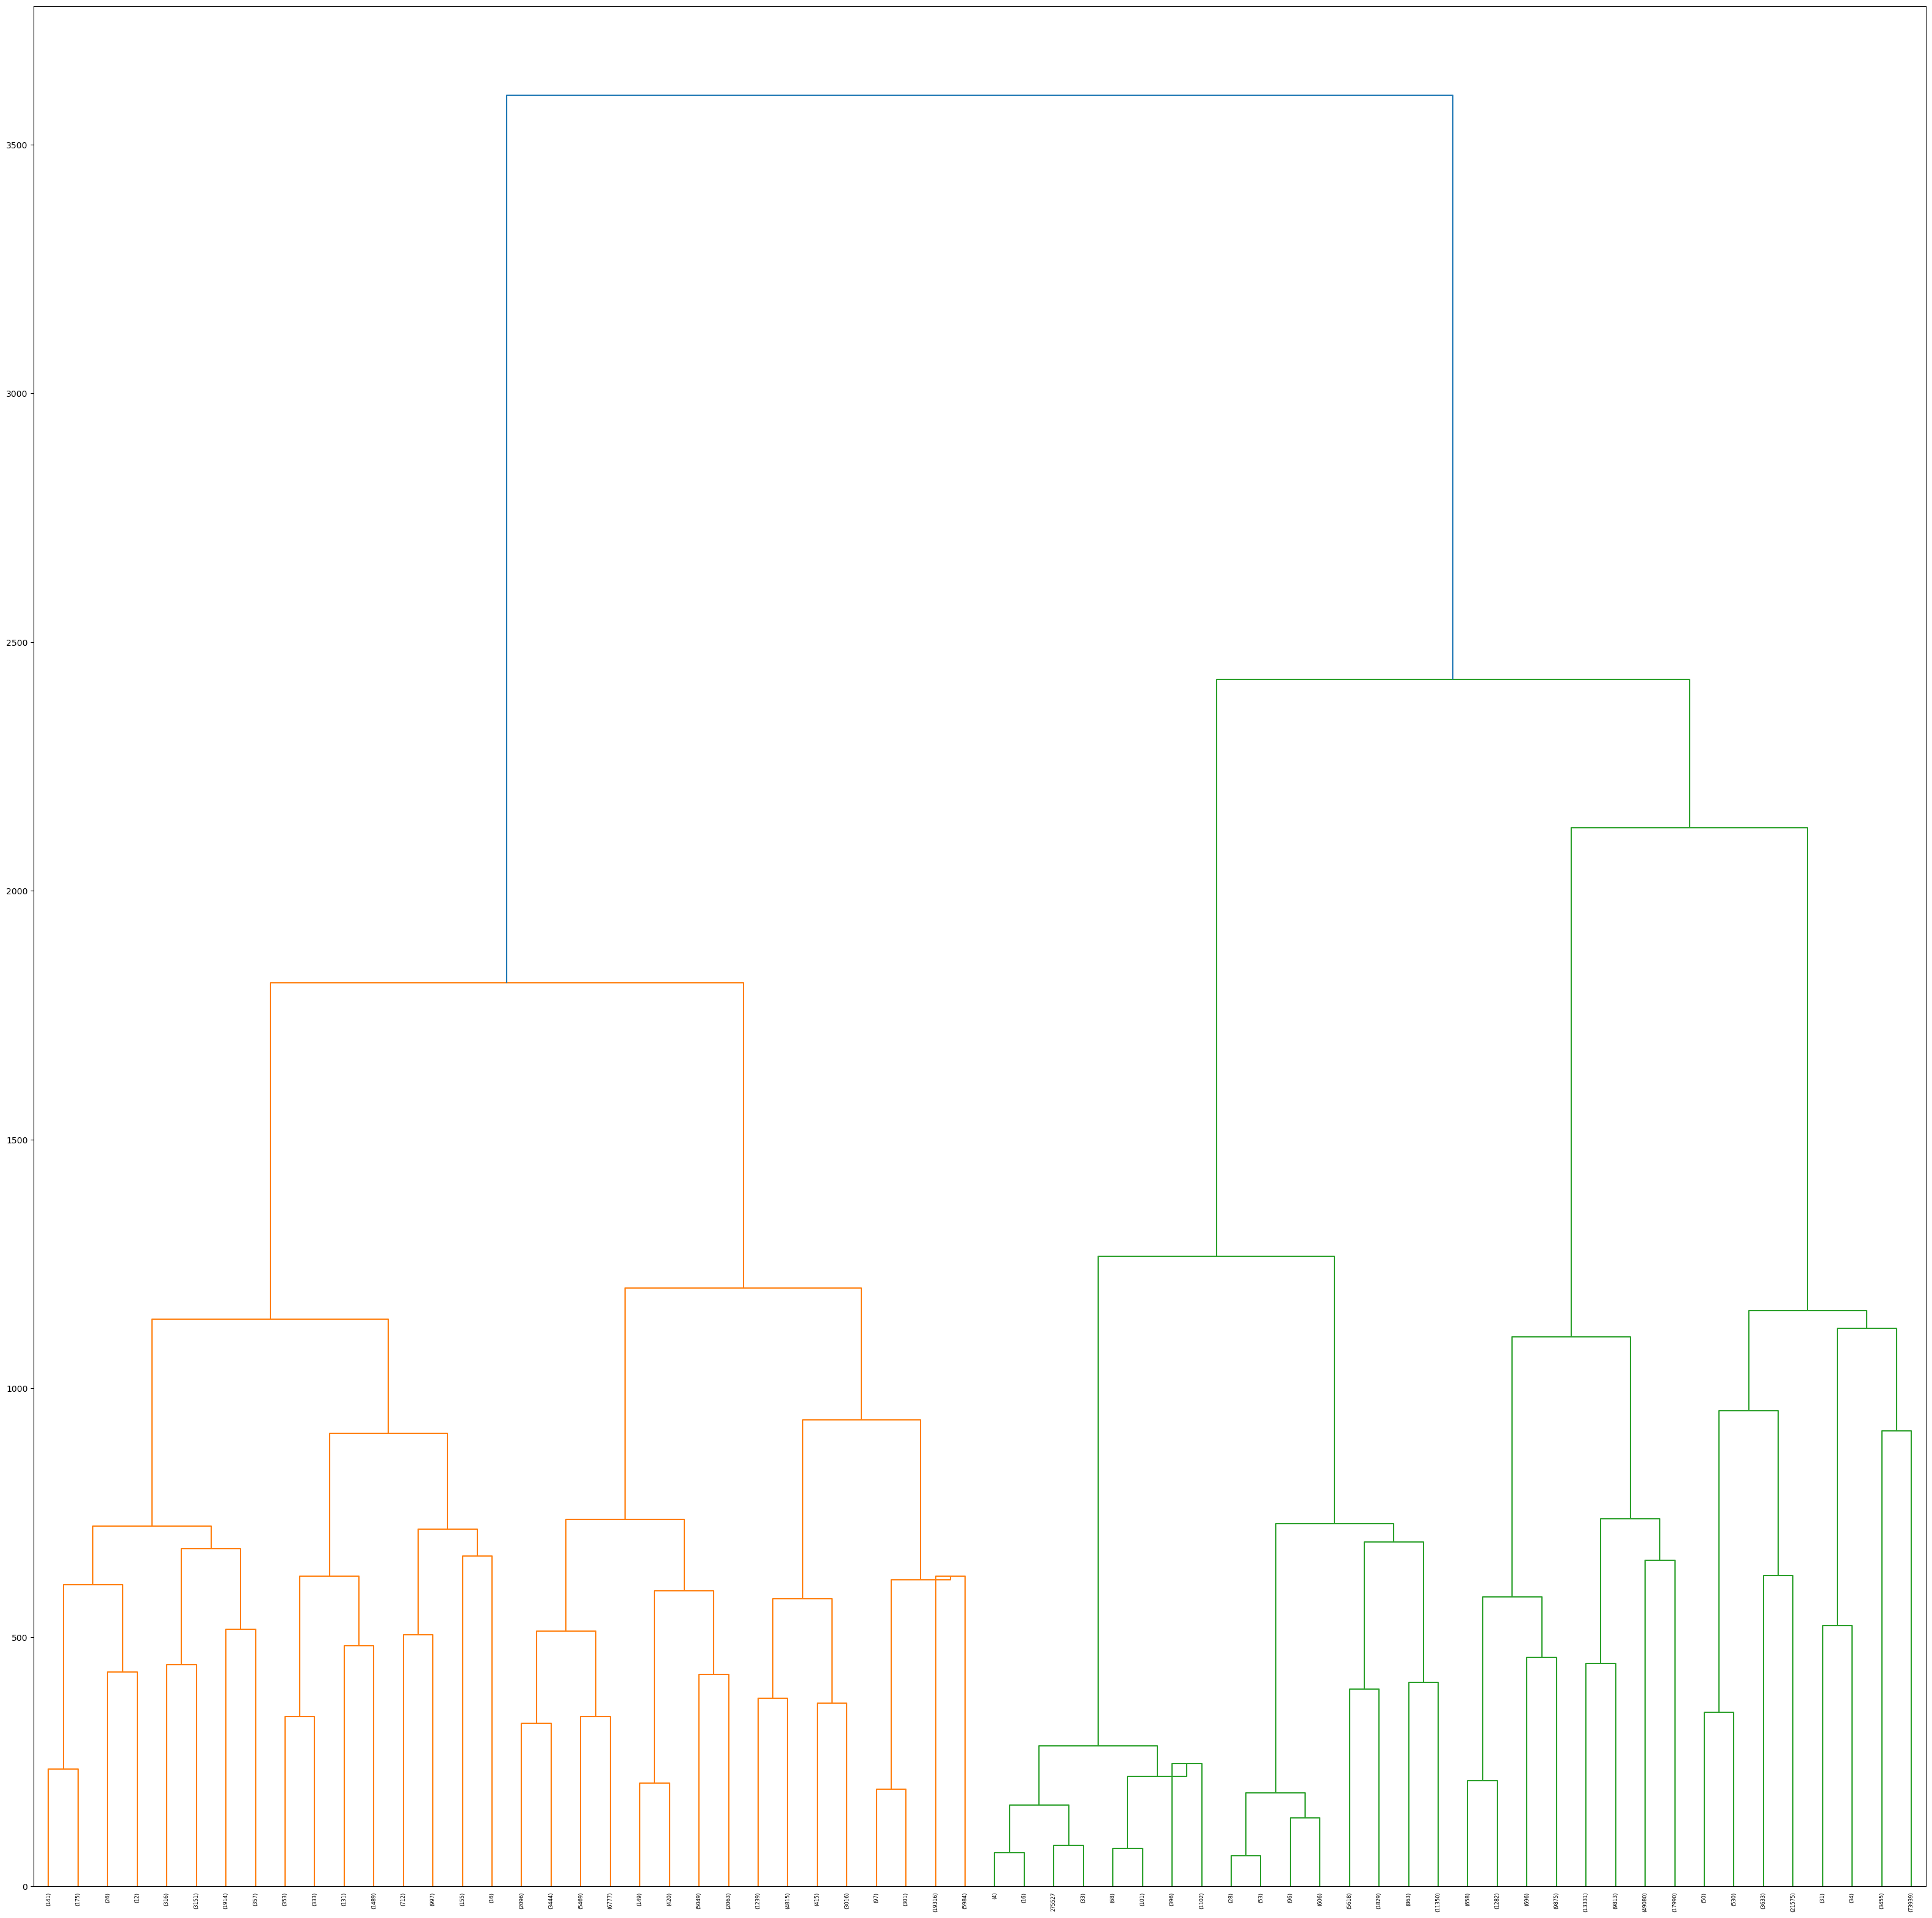

In [28]:
fix, ax = plt.subplots(figsize=(40,40))
# Plot the corresponding dendrogram
_ = dendrogram(linkage_matrix, truncate_mode="level", p=5, ax=ax)

In [64]:
%%time
import lonboard
plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.PolygonLayer.from_geopandas(plotting, opacity=.15)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 4.75 s, sys: 443 ms, total: 5.2 s
Wall time: 5.19 s


In [65]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [66]:
from core.cluster_validation import get_color

In [33]:
for t in range(100, 1250, 100):
    r = fcluster(linkage_matrix, t=t, criterion='distance')
    # r = pd.Series(r, index=X_train.index)
    # # ssplits = graph.describe(r, statistics=['nunique'])['nunique']
    print(t, ' - ', 
          adjusted_rand_score(tess_groups.values, r[tess_groups_ilocs]),
          # (ssplits > 1).sum() / ssplits.shape[0],
          davies_bouldin_score(X_train, r)
         )

100  -  0.4049830800975384 2.5410040015748736
200  -  0.6273467681124375 3.071999317201042
300  -  0.8142824914737531 3.310979252953551
400  -  0.560642346172601 3.040779981884746
500  -  0.5601159895020611 2.956676977958116
600  -  0.5601159895020611 3.0960439636420505
700  -  0.38933555009716 3.110222436805863
800  -  0.38915989102481724 2.9786025570860084
900  -  0.38915989102481724 2.9786025570860084
1000  -  0.40548623013332885 3.0734523316448916
1100  -  0.40548623013332885 3.0734523316448916
1200  -  0.3624451201533742 3.092684544891082


In [103]:
clusters = fcluster(linkage_matrix, t=300, criterion='distance')

In [104]:
np.unique(clusters, return_counts=True)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127], dtype=int32),
 array([  316,    26,    12,   316,  1048,  2103,  1001,   913,    62,
          295,   353,   333,   131,   325,   893,   271,   384,   328,
          728,   269,   155,     3,    13,  2096,  3444,  5469,  6777,
          569,   983,  4066,  1440,   623,  1239,  2441, 

In [105]:
layer.get_fill_color = get_color(clusters)

In [192]:
sklearn_tree = KDTree(X_train.values)
numba_tree = kdtree_to_numba(sklearn_tree)

In [193]:
from core.cluster_validation import generate_neigbhourhood_groups

In [194]:
groups = generate_neigbhourhood_groups(tessellation)

In [195]:
karlins = groups[groups == 'karlin'].index.values

In [196]:
tess_id = 261793

In [197]:
# tessellation.loc[graph[tess_id].index.values].explore()

In [198]:
graph[tess_id].index.values

array([261783, 261788, 261789, 261793, 261796, 261800, 261819])

In [199]:
xilocs = np.where(X_train.index.isin(graph[tess_id].index.values))[0]

In [200]:
num_neighbours = 15

In [201]:
nn_dists, nn_inds = parallel_tree_query(numba_tree, np.ascontiguousarray(X_train.iloc[xilocs].values), k=num_neighbours)

In [202]:
neigh_ids = nn_inds[3]
neigh_dists = nn_dists[3]

In [203]:
neighbours = tessellation.loc[X_train.iloc[neigh_ids].index].reset_index()
neighbours['nn_dists'] = neigh_dists
neighbours['nn_order'] = np.arange(num_neighbours)

In [204]:
intersection = np.intersect1d(X_train.iloc[neigh_ids].index, graph[tess_id].index.values)
union = np.union1d(X_train.iloc[neigh_ids].index, graph[tess_id].index.values)

print('graph intersection: ', intersection.shape[0] / graph[tess_id].index.values.shape[0],
      'total intersection: ', intersection.shape[0]/union.shape[0])

graph intersection:  0.2857142857142857 total intersection:  0.1


In [213]:
from scipy.spatial.distance import pdist, cdist

array([ -5490,  -5490,  -5490, ..., 299063, 299063, 299063])

In [211]:
pdist(X_train.iloc[neigh_ids].values)

array([4.87532534, 5.08568228, 5.11036757, 5.3147674 , 5.3152624 ,
       5.31833994, 5.33959303, 5.34781153, 5.39578952, 5.41562768,
       5.46998235, 5.4751668 , 5.49217131, 5.50442596, 5.52366858,
       5.57984761, 5.44336868, 4.68245219, 5.81689727, 5.0899599 ,
       4.16571699, 4.86319586, 6.39377622, 4.93296405, 5.88576494,
       5.6822102 , 5.95724033, 5.23491609, 4.23075501, 4.81238908,
       6.80725969, 6.2814186 , 4.59715491, 4.52383647, 1.98955439,
       5.07671347, 6.32379318, 5.44723154, 5.518125  , 4.73477739,
       3.94028481, 5.10790316, 5.81491372, 5.09931867, 5.38463478,
       5.85268679, 4.56028338, 5.33840232, 5.06143164, 3.29403048,
       3.70073265, 6.51971316, 6.62836994, 5.00794782, 5.37130085,
       5.17112032, 6.0416938 , 6.48024856, 4.76729681, 6.2082616 ,
       5.47793756, 5.79603626, 4.42257168, 5.81657086, 5.56597565,
       5.38856602, 5.73479756, 4.45769596, 4.87576705, 4.02241014,
       6.44749171, 6.31187573, 7.46502314, 5.92518848, 3.97234

In [380]:
# m = neighbours.explore()
# m = tessellation.loc[[tess_id]].explore(color='red', m=m)
# m

In [206]:
X_train.iloc[neigh_ids]

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,...,stcSAl,ldkAre,ldkPer,lskCCo,lskERI,lskCWA,ltkOri,ltkWNB,likWBB,sdsAre
261793,0.399284,1.170116,-0.02239,-1.814340,-0.637299,-0.305332,0.635863,-1.971834,2.203463,-0.550868,...,-0.844166,-0.500347,-0.555598,1.468550,1.051844,-0.695529,0.161561,0.047395,2.629321,-0.396684
116039,0.305006,0.725154,-0.02239,0.087126,-0.637299,-0.343731,0.609423,-0.624599,1.266895,-0.575372,...,-0.670972,-0.510141,-0.574152,1.807997,1.149733,-0.731008,0.142096,0.047964,1.566661,-0.219880
235733,0.107570,0.617780,-0.02239,-1.988388,-0.637299,-0.220512,0.623702,-2.050118,1.379239,-0.540936,...,-0.802506,-0.574580,-0.656832,1.395335,1.157807,-0.762063,0.044643,0.150431,3.237948,-0.323684
242470,0.057450,0.426782,-0.02239,-1.530537,-0.637299,-0.369077,0.601152,-1.809503,1.028426,-0.579041,...,-0.195215,-0.529519,-0.575120,0.260475,1.025390,-0.657860,-0.982306,0.048788,2.888012,-0.342812
236829,0.630815,1.350235,-0.02239,-1.014296,-0.637299,-0.042947,0.611460,-1.451214,2.309372,-0.391424,...,-0.959591,-0.572121,-0.645981,0.830897,0.964403,-0.735043,0.268851,0.099317,3.937440,-0.339094
282617,0.386274,0.992790,-0.02239,-0.984762,-0.637299,-0.383045,0.627505,-1.502184,1.796915,-0.586188,...,-0.936444,-0.541114,-0.602275,1.191243,1.052597,-0.721296,-0.553007,0.040427,3.019633,-0.411958
261789,-0.181041,-0.395971,-0.02239,-0.734107,-0.637299,-0.390733,0.625213,-1.337652,-0.259510,-0.592120,...,-0.843178,-0.500347,-0.555598,1.468550,1.051844,-0.695529,0.161561,0.047395,2.629321,-0.396684
230350,-0.129525,-0.177631,-0.02239,-0.979320,-0.637299,-0.276331,0.646393,-1.469099,0.077922,-0.571480,...,-0.780903,-0.594039,-0.700705,1.045393,1.062087,-0.769830,-0.665001,0.157594,1.818376,-0.407993
272435,0.630769,1.193292,-0.02239,0.020450,-0.637299,-0.112657,0.575050,-0.522858,1.920432,-0.471399,...,-0.468349,-0.565854,-0.639842,1.569107,1.067973,-0.749727,-0.388510,0.112164,3.350177,-0.269307
282590,0.233247,0.776884,-0.02239,-1.352580,-0.637299,-0.309804,0.582854,-1.688910,1.529188,-0.552438,...,-0.862768,-0.549967,-0.604904,0.983593,0.820175,-0.698835,-0.361934,0.079422,1.874727,0.000000


In [44]:
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12

def get_color(labels_to_color):

    import glasbey
    
    def hex_to_rgb(hexa):
        return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))
    
    if labels_to_color.max() > 12:
        gb_cols = glasbey.extend_palette(
            Set3_12.hex_colors, palette_size=np.unique(labels_to_color).shape[0] + 1
        )
    else:
        gb_cols = Set3_12.hex_colors
    
    gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]
    
    colors = apply_categorical_cmap(
        labels_to_color, cmap=dict(zip(np.unique(labels_to_color), gb_cols, strict=False))
    )
    return colors